In [1]:
import os
import pickle
from typing import List, Optional

from haystack.dataclasses import ChatMessage
from haystack.utils import Secret
from haystack.components.generators.chat import OpenAIChatGenerator
from typing import List, Dict
from nltk.tokenize import word_tokenize
from haystack import Pipeline, component, Document                                     
from haystack_integrations.document_stores.chroma import ChromaDocumentStore  
from haystack_integrations.components.retrievers.chroma import ChromaQueryTextRetriever
from haystack.components.joiners.document_joiner import DocumentJoiner
from haystack.components.rankers import TransformersSimilarityRanker
from sklearn.metrics import accuracy_score

import re
import pickle
from typing import List, Dict, Optional

from nltk.tokenize import word_tokenize

from haystack import Pipeline, component
from haystack.dataclasses import Document, ChatMessage
from haystack.components.routers import ConditionalRouter
from haystack.components.builders.chat_prompt_builder import ChatPromptBuilder
from haystack.components.joiners.document_joiner import DocumentJoiner
from haystack.components.rankers import TransformersSimilarityRanker
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack_integrations.document_stores.chroma import ChromaDocumentStore
from haystack_integrations.components.retrievers.chroma import ChromaQueryTextRetriever
from haystack.utils import Secret

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 0Ô∏è‚É£ –ö–æ–º–ø–æ–Ω–µ–Ω—Ç—ã
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

@component
class QueryClassifierLLM:
    """
    –ö–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä—É–µ—Ç, –Ω—É–∂–µ–Ω –ª–∏ –ø–æ–∏—Å–∫ (RAG) –¥–ª—è –∑–∞–ø—Ä–æ—Å–∞.
    """
    def __init__(self, generator: OpenAIChatGenerator):
        self.generator = generator
        self.template = """
–¢—ã ‚Äî –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä –∑–∞–ø—Ä–æ—Å–æ–≤ –ø–æ –±–∞–∑–µ –∑–Ω–∞–Ω–∏–π.
–ï—Å–ª–∏ –∑–∞–ø—Ä–æ—Å —Ç—Ä–µ–±—É–µ—Ç –ø–æ–∏—Å–∫–∞ ‚Äî –æ—Ç–≤–µ—Ç—å 'true'. –ï—Å–ª–∏ –º–æ–∂–Ω–æ –æ—Ç–≤–µ—Ç–∏—Ç—å –±–µ–∑ –ø–æ–∏—Å–∫–∞ ‚Äî 'false'.

–ü—Ä–∏–º–µ—Ä—ã:
–ó–∞–ø—Ä–æ—Å: "–ü—Ä–∏–≤–µ—Ç"
–û—Ç–≤–µ—Ç: false

–ó–∞–ø—Ä–æ—Å: "–ö–∞–∫ –¥–µ–ª–∞?"
–û—Ç–≤–µ—Ç: false

–ó–∞–ø—Ä–æ—Å: "–ß—Ç–æ —Ç–∞–∫–æ–µ GDPR?"
–û—Ç–≤–µ—Ç: true

–ó–∞–ø—Ä–æ—Å: "–°–∫–æ–ª—å–∫–æ –¥–Ω–µ–π –æ—Ç–ø—É—Å–∫–∞ –ø–æ–ª–æ–∂–µ–Ω–æ —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–∞–º?"
–û—Ç–≤–µ—Ç: true

–¢–µ–ø–µ—Ä—å –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä—É–π:
–ó–∞–ø—Ä–æ—Å: "{{ query }}"
–û—Ç–≤–µ—Ç:
""".strip()

    @component.output_types(need_search=bool)
    def run(self, query: str) -> Dict[str, bool]:
        prompt = self.template.replace("{{ query }}", query)
        msg = ChatMessage.from_user(prompt)
        out = self.generator.run([msg])
        replies = out.get("replies", [])
        text = replies[0].text.strip().lower() if replies else ""
        return {"need_search": text.startswith("true")}


@component
class QueryDecomposerLLM:
    """
    –ß–µ—Ä–µ–∑ LLM —Ä–µ—à–∞–µ—Ç, –Ω—É–∂–Ω–æ –ª–∏ –¥–µ–∫–æ–º–ø–æ–∑–∏—Ä–æ–≤–∞—Ç—å –∑–∞–ø—Ä–æ—Å, –∏ –≥–µ–Ω–µ—Ä–∏—Ä—É–µ—Ç subqueries.
    """
    def __init__(self, generator: OpenAIChatGenerator):
        self.generator = generator
        self.check_template = """
–¢—ã ‚Äî —ç–∫—Å–ø–µ—Ä—Ç –ø–æ –æ–±—Ä–∞–±–æ—Ç–∫–µ –∑–∞–ø—Ä–æ—Å–æ–≤.
–ï—Å–ª–∏ –∑–∞–ø—Ä–æ—Å —Å–ª–æ–∂–Ω—ã–π –∏ —Å—Ç–æ–∏—Ç —Ä–∞–∑–±–∏—Ç—å –µ–≥–æ –Ω–∞ –ø–æ–¥‚Äë–≤–æ–ø—Ä–æ—Å—ã ‚Äî 'true', –∏–Ω–∞—á–µ ‚Äî 'false'.

–ü—Ä–∏–º–µ—Ä—ã:
–ó–∞–ø—Ä–æ—Å: "–†–∞—Å—Å–∫–∞–∂–∏ –æ –Ω–æ–≤—ã—Ö –ø–æ–ª–∏—Ç–∏–∫–∞—Ö –æ—Ç–ø—É—Å–∫–∞ –∏ —Å–∫–æ–ª—å–∫–æ –¥–Ω–µ–π —Ç–µ–ø–µ—Ä—å –ø–æ–ª–æ–∂–µ–Ω–æ?"
–û—Ç–≤–µ—Ç: true

–ó–∞–ø—Ä–æ—Å: "–ß—Ç–æ —Ç–∞–∫–æ–µ GDPR?"
–û—Ç–≤–µ—Ç: false

–¢–µ–ø–µ—Ä—å –æ—Ü–µ–Ω–∏:
–ó–∞–ø—Ä–æ—Å: "{{ query }}"
–û—Ç–≤–µ—Ç:
""".strip()
        self.decomp_template = """
–¢—ã ‚Äî —Å–ø–µ—Ü–∏–∞–ª–∏—Å—Ç –ø–æ –¥–µ–∫–æ–º–ø–æ–∑–∏—Ü–∏–∏.
–†–∞–∑–±–µ–π –∑–∞–ø—Ä–æ—Å –Ω–∞ –∫–æ—Ä–æ—Ç–∫–∏–µ –Ω–µ–∑–∞–≤–∏—Å–∏–º—ã–µ –ø–æ–¥‚Äë–≤–æ–ø—Ä–æ—Å—ã, –∫–∞–∂–¥—ã–π –Ω–∞ –Ω–æ–≤–æ–π —Å—Ç—Ä–æ–∫–µ.

–ü—Ä–∏–º–µ—Ä—ã:
–û—Ä–∏–≥–∏–Ω–∞–ª: "–†–∞—Å—Å–∫–∞–∂–∏ –æ –Ω–æ–≤—ã—Ö –ø–æ–ª–∏—Ç–∏–∫–∞—Ö –æ—Ç–ø—É—Å–∫–∞ –∏ —Å–∫–æ–ª—å–∫–æ –¥–Ω–µ–π —Ç–µ–ø–µ—Ä—å –ø–æ–ª–æ–∂–µ–Ω–æ?"
- –†–∞—Å—Å–∫–∞–∂–∏ –æ –Ω–æ–≤—ã—Ö –ø–æ–ª–∏—Ç–∏–∫–∞—Ö –æ—Ç–ø—É—Å–∫–∞.
- –°–∫–æ–ª—å–∫–æ –¥–Ω–µ–π –æ—Ç–ø—É—Å–∫–∞ —Ç–µ–ø–µ—Ä—å –ø–æ–ª–æ–∂–µ–Ω–æ?

–¢–µ–ø–µ—Ä—å —Ä–∞–∑–±–µ–π:
–û—Ä–∏–≥–∏–Ω–∞–ª: "{{ query }}"
""".strip()

    @component.output_types(subqueries=List[str])
    def run(self, query: str) -> Dict[str, List[str]]:
        # 1) –ü—Ä–æ–≤–µ—Ä—è–µ–º –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ—Å—Ç—å —Ä–∞–∑–±–∏–≤–∫–∏
        check_prompt = self.check_template.replace("{{ query }}", query)
        check_msg = ChatMessage.from_user(check_prompt)
        check_out = self.generator.run([check_msg])
        dec = check_out.get("replies", [])
        needs = dec[0].text.strip().lower().startswith("true") if dec else False

        if not needs:
            return {"subqueries": [query]}

        # 2) –ì–µ–Ω–µ—Ä–∏—Ä—É–µ–º –ø–æ–¥‚Äë–≤–æ–ø—Ä–æ—Å—ã
        decomp_prompt = self.decomp_template.replace("{{ query }}", query)
        decomp_msg = ChatMessage.from_user(decomp_prompt)
        decomp_out = self.generator.run([decomp_msg])
        raw = decomp_out.get("replies", [])[0].text or ""
        parts = [line.strip("- ").strip() for line in raw.splitlines() if line.strip()]
        return {"subqueries": parts}

@component
class QueryCleaner:
    """
    –ü—Ä–∏–≤–æ–¥–∏—Ç —Å—Ç—Ä–æ–∫—É –∫ –Ω–∏–∂–Ω–µ–º—É —Ä–µ–≥–∏—Å—Ç—Ä—É, —Ç–æ–∫–µ–Ω–∏–∑–∏—Ä—É–µ—Ç –∏ –æ—Å—Ç–∞–≤–ª—è–µ—Ç —Ç–æ–ª—å–∫–æ —Å–ª–æ–≤–æ-—á–∏—Å–ª–æ–≤—ã–µ —Ç–æ–∫–µ–Ω—ã.
    """
    @component.output_types(query=str)
    def run(self, query: str) -> Dict[str, str]:
        q = query.lower()
        tokens = word_tokenize(q)
        filt = [t for t in tokens if re.fullmatch(r"\w+", t)]
        return {"query": " ".join(filt)}

@component
class PickledBM25Retriever:
    """
    Sparse Retriever –Ω–∞ –æ—Å–Ω–æ–≤–µ –∑–∞—Ä–∞–Ω–µ–µ –ø–æ—Å—Ç—Ä–æ–µ–Ω–Ω–æ–≥–æ BM25-–∏–Ω–¥–µ–∫—Å–∞ –≤ pickle.
    """
    def __init__(
        self,
        document_store: ChromaDocumentStore,
        path_to_pickle: str,
        top_k: int = 5
    ):
        self.top_k = top_k
        self.path = path_to_pickle
        # –∑–∞–≥—Ä—É–∑–∫–∞ –≤—Å–µ—Ö –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤ –¥–ª—è –±—ã—Å—Ç—Ä–æ–≥–æ –¥–æ—Å—Ç—É–ø–∞
        all_docs = document_store.filter_documents(filters={})
        self.doc_map = {d.id: d for d in all_docs}

    @component.output_types(documents=List[Document])
    def run(self, query: str, top_k: Optional[int] = None) -> Dict[str, List[Document]]:
        k = top_k or self.top_k
        with open(self.path, "rb") as f:
            bm25, doc_ids = pickle.load(f)
        tokens = word_tokenize(query.lower())
        scores = bm25.get_scores(tokens)
        top_idxs = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:k]
        docs = [self.doc_map[doc_ids[i]] for i in top_idxs if doc_ids[i] in self.doc_map]
        return {"documents": docs}

import logging
from typing import List, Dict
from haystack.dataclasses import ChatMessage
from haystack import component, Document

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏—è
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

@component
class MultiQueryHandler:
    """
    –î–ª—è —Å–ø–∏—Å–∫–∞ subqueries –≤—ã–ø–æ–ª–Ω—è–µ—Ç –ø–æ–∏—Å–∫+–≥–µ–Ω–µ—Ä–∞—Ü–∏—é, –∞ –∑–∞—Ç–µ–º –∞–≥—Ä–µ–≥–∏—Ä—É–µ—Ç –æ—Ç–≤–µ—Ç—ã —Å –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏–µ–º.
    """
    def __init__(
        self,
        bm25,
        chroma,
        joiner,
        ranker,
        prompt_builder,
        generator
    ):
        self.bm25 = bm25
        self.chroma = chroma
        self.joiner = joiner
        self.ranker = ranker
        self.pb = prompt_builder
        self.gen = generator
        self.logger = logging.getLogger(self.__class__.__name__)

    @component.output_types(answer=str)
    def run(self, multi: List[str], original_query: str) -> Dict[str, str]:
        self.logger.debug("Starting MultiQueryHandler.run: original_query='%s', multi=%s", original_query, multi)
        parts = []
        # –û–≥—Ä–∞–Ω–∏—á–∏–≤–∞–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ–¥–∑–∞–ø—Ä–æ—Å–æ–≤ —Ç—Ä–µ–º—è
        limited_multi = multi[:3]
        if len(multi) > 3:
            self.logger.debug("–û–≥—Ä–∞–Ω–∏—á–∏–≤–∞–µ–º —á–∏—Å–ª–æ –ø–æ–¥–∑–∞–ø—Ä–æ—Å–æ–≤ —Å %d –¥–æ 3", len(multi))

        for sq in limited_multi:
            self.logger.debug("Processing subquery: '%s'", sq)
            try:
                # retrieval
                d1 = self.bm25.run(query=sq)["documents"]
                self.logger.debug("BM25 returned %d documents", len(d1))
                d2 = self.chroma.run(query=sq)["documents"]
                self.logger.debug("Chroma returned %d documents", len(d2))

                # join + rank (reciprocal rank fusion)
                jdocs = self.joiner.run(documents=[d1, d2])["documents"]
                self.logger.debug("After joiner: %d documents", len(jdocs))
                rdocs = self.ranker.run(documents=jdocs, query=sq)["documents"]
                self.logger.debug("After ranker: %d documents", len(rdocs))

                # –û–≥—Ä–∞–Ω–∏—á–∏–≤–∞–µ–º —Ä–∞–∑–º–µ—Ä –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤ –¥–æ 200 —Å–∏–º–≤–æ–ª–æ–≤
                # truncated_docs: List[Document] = []
                # for doc in rdocs:
                #     content = doc.content or ""
                #     truncated_content = content[:30] if len(content) > 30 else content
                #     truncated_docs.append(Document(content=truncated_content, id=doc.id, score=doc.score, meta=doc.meta))
                # self.logger.debug("–î–æ–∫—É–º–µ–Ω—Ç—ã –ø–æ—Å–ª–µ —É—Å–µ—á–µ–Ω–∏—è: %s", [len(d.content) for d in truncated_docs])
            
                # prompt & generation
                messages = self.pb.run(query=sq, documents=rdocs)["prompt"]
                self.logger.debug("Generated prompt messages: %s", messages)
                out = self.gen.run(messages)
                self.logger.debug("Generator output: %s", out)
                text = out.get("replies", [])[0].text or ""
                parts.append(text)
            except Exception as e:
                self.logger.error("Error processing subquery '%s': %s", sq, e, exc_info=True)

        if not parts:
            self.logger.debug("No parts generated, returning default message.")
            return {"answer": "–ò–∑–≤–∏–Ω–∏—Ç–µ, –ø–æ –≤–∞—à–µ–º—É –∑–∞–ø—Ä–æ—Å—É –Ω–∏—á–µ–≥–æ –Ω–µ –Ω–∞–π–¥–µ–Ω–æ."}

        # —Ñ–∏–Ω–∞–ª—å–Ω–∞—è –∞–≥—Ä–µ–≥–∞—Ü–∏—è
        summary = (
            f"–ù–∞ –æ—Å–Ω–æ–≤–µ –æ—Ç–≤–µ—Ç–æ–≤ –Ω–∞ —á–∞—Å—Ç–∏ –≤–æ–ø—Ä–æ—Å–∞ ¬´{original_query}¬ª "
            "—Å–æ–±–µ—Ä–∏ –µ–¥–∏–Ω—ã–π —Å–≤—è–∑–Ω—ã–π –æ—Ç–≤–µ—Ç:\n"
        )
        for i, p in enumerate(parts, 1):
            summary += f"–ß–∞—Å—Ç—å {i}: {p}\n"
        self.logger.debug("Aggregation prompt: %s", summary)
        sum_msg = ChatMessage.from_user(summary)
        sum_out = self.gen.run([sum_msg])
        agg = sum_out.get("replies", [])[0].text or ""
        self.logger.debug("Final aggregated answer: %s", agg)
        return {"answer": agg}


@component
class ResponseSelector:
    """
    –í—ã–±–∏—Ä–∞–µ—Ç —Ñ–∏–Ω–∞–ª—å–Ω—ã–π –æ—Ç–≤–µ—Ç –∏–∑:
      - multi_answer (–µ—Å–ª–∏ –∑–∞–¥–∞–Ω)
      - –∏–Ω–∞—á–µ rag_replies[0]
      - –∏–Ω–∞—á–µ chat_replies[0]
    """
    @component.output_types(answer=str)
    def run(
        self,
        chat_replies: Optional[List[ChatMessage]] = None,
        rag_replies:  Optional[List[ChatMessage]] = None,
        multi_answer: Optional[str]            = None
    ) -> dict:
        if multi_answer:
            return {"answer": multi_answer}
        if rag_replies:
            return {"answer": rag_replies[0].text}
        if chat_replies:
            return {"answer": chat_replies[0].text}
        return {"answer": ""}

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 1Ô∏è‚É£ –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –º–æ–¥–µ–ª–µ–π –∏ —Ä–µ—Ç—Ä–∏–≤–µ—Ä–æ–≤
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# MODEL_NAME = "hf.co/IlyaGusev/saiga_nemo_12b_gguf:Q8_0"
MODEL_NAME = "hf.co/IlyaGusev/saiga_yandexgpt_8b_gguf:Q4_0"
gen_conv = OpenAIChatGenerator(
    model=MODEL_NAME,
    api_key=Secret.from_token("ollama"),
    api_base_url="http://localhost:11434/v1",
    generation_kwargs={"temperature": 0.8, "max_tokens": 1000, "timeout": 60}
)

gen_rag = OpenAIChatGenerator(
    model=MODEL_NAME,
    api_key=Secret.from_token("ollama"),
    api_base_url="http://localhost:11434/v1",
    generation_kwargs={"temperature": 0.8, "max_tokens": 1000, "timeout": 60}
)

gen_multi = OpenAIChatGenerator(
    model=MODEL_NAME,
    api_key=Secret.from_token("ollama"),
    api_base_url="http://localhost:11434/v1",
    generation_kwargs={"temperature": 0.8, "max_tokens": 1000, "timeout": 60}
)

ds        = ChromaDocumentStore(persist_path="../data/chroma_index")
bm25      = PickledBM25Retriever(ds, "../data/bm25.pkl", top_k=5)
chroma    = ChromaQueryTextRetriever(document_store=ds, top_k=5)
joiner    = DocumentJoiner(join_mode="reciprocal_rank_fusion", top_k=10)
ranker = TransformersSimilarityRanker(model="cross-encoder/ms-marco-TinyBERT-L-2-v2", top_k=5)
ranker.warm_up()

# PromptBuilder –¥–ª—è –ø—Ä–æ—Å—Ç–æ–π –±–µ—Å–µ–¥—ã (no_search)
conv_pb = ChatPromptBuilder(
    template=[
        ChatMessage.from_system("–¢—ã ‚Äî –¥—Ä—É–∂–µ–ª—é–±–Ω—ã–π –ø–æ–º–æ—â–Ω–∏–∫."),
        ChatMessage.from_user("{{ query }}")
    ],
    required_variables=["query"]
)

# PromptBuilder –¥–ª—è RAG‚Äë–æ—Ç–≤–µ—Ç–∞ (single + multi parts)
rag_pb = ChatPromptBuilder(
    template=[
        ChatMessage.from_system("–¢—ã ‚Äî —ç–∫—Å–ø–µ—Ä—Ç –ø–æ –±–∞–∑–µ –∑–Ω–∞–Ω–∏–π."),
        ChatMessage.from_user(
            "–í–æ–ø—Ä–æ—Å: {{ query }}\n\n"
            "–ö–æ–Ω—Ç–µ–∫—Å—Ç:\n{% for doc in documents %}- {{ doc.content }}\n{% endfor %}\n\n"
            "–û—Ç–≤–µ—Ç—å –ø–æ–¥—Ä–æ–±–Ω–æ –∏ —É–∫–∞–∂–∏ –∏—Å—Ç–æ—á–Ω–∏–∫–∏:"
        )
    ],
    required_variables=["query", "documents"]
)

# multi_handler = MultiQueryHandler(
#     bm25=bm25,
#     chroma=chroma,
#     joiner=joiner,
#     ranker=ranker,
#     prompt_builder=rag_pb,
#     generator=gen_nulti
# )


# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 2Ô∏è‚É£ –°–±–æ—Ä–∫–∞ Pipeline
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
pipe = Pipeline()

# 2.1 Classifier ‚Üí router1
pipe.add_component("classifier", QueryClassifierLLM(generator=gen_conv))
pipe.add_component("router1", ConditionalRouter(routes=[
    {"condition": "{{ need_search == false }}",
     "output": "{{ query }}", "output_name": "no_search", "output_type": str},
    {"condition": "{{ need_search == true  }}",
     "output": "{{ query }}", "output_name": "to_search", "output_type": str},
]))
pipe.connect("classifier.need_search", "router1.need_search")

# 2.2 no_search: –±–µ—Å–µ–¥–∞ –±–µ–∑ –ø–æ–∏—Å–∫–∞
pipe.add_component("conv_pb",  conv_pb)
pipe.add_component("chat_gen", gen_conv)
pipe.connect("router1.no_search", "conv_pb.query")
pipe.connect("conv_pb.prompt",  "chat_gen.messages")

# 2.3 to_search ‚Üí –¥–µ–∫–æ–º–ø–æ–∑–∏—Ü–∏—è
pipe.add_component("decomposer", QueryDecomposerLLM(generator=gen_rag))
pipe.connect("router1.to_search", "decomposer.query")

pipe.add_component("router2", ConditionalRouter(routes=[
    {"condition": "{{ subqueries|length > 1 }}",
     "output": "{{ subqueries }}",     "output_name": "multi",  "output_type": list[str]},
    {"condition": "{{ subqueries|length <= 1 }}",
     "output": "{{ subqueries[0] }}", "output_name": "single","output_type": str},
]))
pipe.connect("decomposer.subqueries", "router2.subqueries")

# 2.4 single ‚Üí –ø–æ–∏—Å–∫ + –≥–µ–Ω–µ—Ä–∞—Ü–∏—è
pipe.add_component("cleaner", QueryCleaner())
pipe.add_component("bm25",    bm25)
pipe.add_component("chroma",  chroma)
pipe.add_component("joiner",  joiner)
pipe.add_component("ranker",  ranker)
pipe.add_component("rag_pb",  rag_pb)
pipe.add_component("rag_gen", gen_rag)

pipe.connect("router2.single",   "cleaner.query")
pipe.connect("cleaner.query",    "bm25.query")
pipe.connect("cleaner.query",    "chroma.query")
pipe.connect("bm25.documents",   "joiner.documents")
pipe.connect("chroma.documents", "joiner.documents")
pipe.connect("joiner.documents", "ranker.documents")

pipe.connect("router2.single",   "rag_pb.query")
pipe.connect("ranker.documents", "rag_pb.documents")
pipe.connect("rag_pb.prompt",    "rag_gen.messages")

# 2.5 multi ‚Üí MultiQueryHandler
multi_handler = MultiQueryHandler(
    bm25=bm25,
    chroma=chroma,
    joiner=pipe.get_component("joiner"),
    ranker=pipe.get_component("ranker"),
    prompt_builder=rag_pb,
    generator=gen_multi
)
pipe.add_component("multi_handler", multi_handler)
# pipe.add_component("multi_handler", )
pipe.connect("router2.multi",     "multi_handler.multi")
pipe.connect("router1.to_search", "multi_handler.original_query")

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# –ø–æ—Å–ª–µ –≤—Å–µ—Ö –æ—Å—Ç–∞–ª—å–Ω—ã—Ö add_component/ connect(...)‚Ä¶
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
pipe.add_component("selector", ResponseSelector())

# chat_gen ‚Äî –≤–µ—Ç–≤—å no_search
pipe.connect("chat_gen.replies",       "selector.chat_replies")

# rag_gen  ‚Äî –≤–µ—Ç–≤—å single
pipe.connect("rag_gen.replies",        "selector.rag_replies")

# multi_handler ‚Äî –≤–µ—Ç–≤—å multi
pipe.connect("multi_handler.answer",   "selector.multi_answer")


DEBUG:haystack.core.component.component:Registering <class '__main__.MultiQueryHandler'> as a component
DEBUG:haystack.core.component.component:Registered Component <class '__main__.MultiQueryHandler'>
DEBUG:haystack.core.component.component:Registering <class '__main__.ResponseSelector'> as a component
DEBUG:haystack.core.component.component:Registered Component <class '__main__.ResponseSelector'>
INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
DEBUG:chromadb.config:Starting component System
DEBUG:chromadb.config:Starting component Posthog
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): eu.i.posthog.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://eu.i.posthog.com:443 "POST /batch/ HTTP/1.1" 200 15
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /cross-encoder/ms-marco-TinyB

üöÖ Components
  - classifier: QueryClassifierLLM
  - router1: ConditionalRouter
  - conv_pb: ChatPromptBuilder
  - chat_gen: OpenAIChatGenerator
  - decomposer: QueryDecomposerLLM
  - router2: ConditionalRouter
  - cleaner: QueryCleaner
  - bm25: PickledBM25Retriever
  - chroma: ChromaQueryTextRetriever
  - joiner: DocumentJoiner
  - ranker: TransformersSimilarityRanker
  - rag_pb: ChatPromptBuilder
  - rag_gen: OpenAIChatGenerator
  - multi_handler: MultiQueryHandler
  - selector: ResponseSelector
üõ§Ô∏è Connections
  - classifier.need_search -> router1.need_search (bool)
  - router1.no_search -> conv_pb.query (str)
  - router1.to_search -> decomposer.query (str)
  - router1.to_search -> multi_handler.original_query (str)
  - conv_pb.prompt -> chat_gen.messages (List[ChatMessage])
  - chat_gen.replies -> selector.chat_replies (List[ChatMessage])
  - decomposer.subqueries -> router2.subqueries (List[str])
  - router2.single -> cleaner.query (str)
  - router2.single -> rag_pb.query (

DEBUG:haystack.core.pipeline.draw:Mermaid diagram:

%%{ init: {"theme": "neutral"} }%%

graph TD;

classifier["<b>classifier</b><br><small><i>QueryClassifierLLM</i></small>"]:::component -- "need_search -> need_search<br><small><i>bool</i></small>" --> router1["<b>router1</b><br><small><i>ConditionalRouter</i></small>"]:::component
router1["<b>router1</b><br><small><i>ConditionalRouter</i></small>"]:::component -- "no_search -> query<br><small><i>str</i></small>" --> conv_pb["<b>conv_pb</b><br><small><i>ChatPromptBuilder<br><br>Optional inputs:<ul style='text-align:left;'><li>template (Optional[List[ChatMessage]])</li><li>template_variables (Optional[Dict[str, Any]])</li></ul></i></small>"]:::component
router1["<b>router1</b><br><small><i>ConditionalRouter</i></small>"]:::component -- "to_search -> query<br><small><i>str</i></small>" --> decomposer["<b>decomposer</b><br><small><i>QueryDecomposerLLM</i></small>"]:::component
router1["<b>router1</b><br><small><i>ConditionalRouter</i></sm

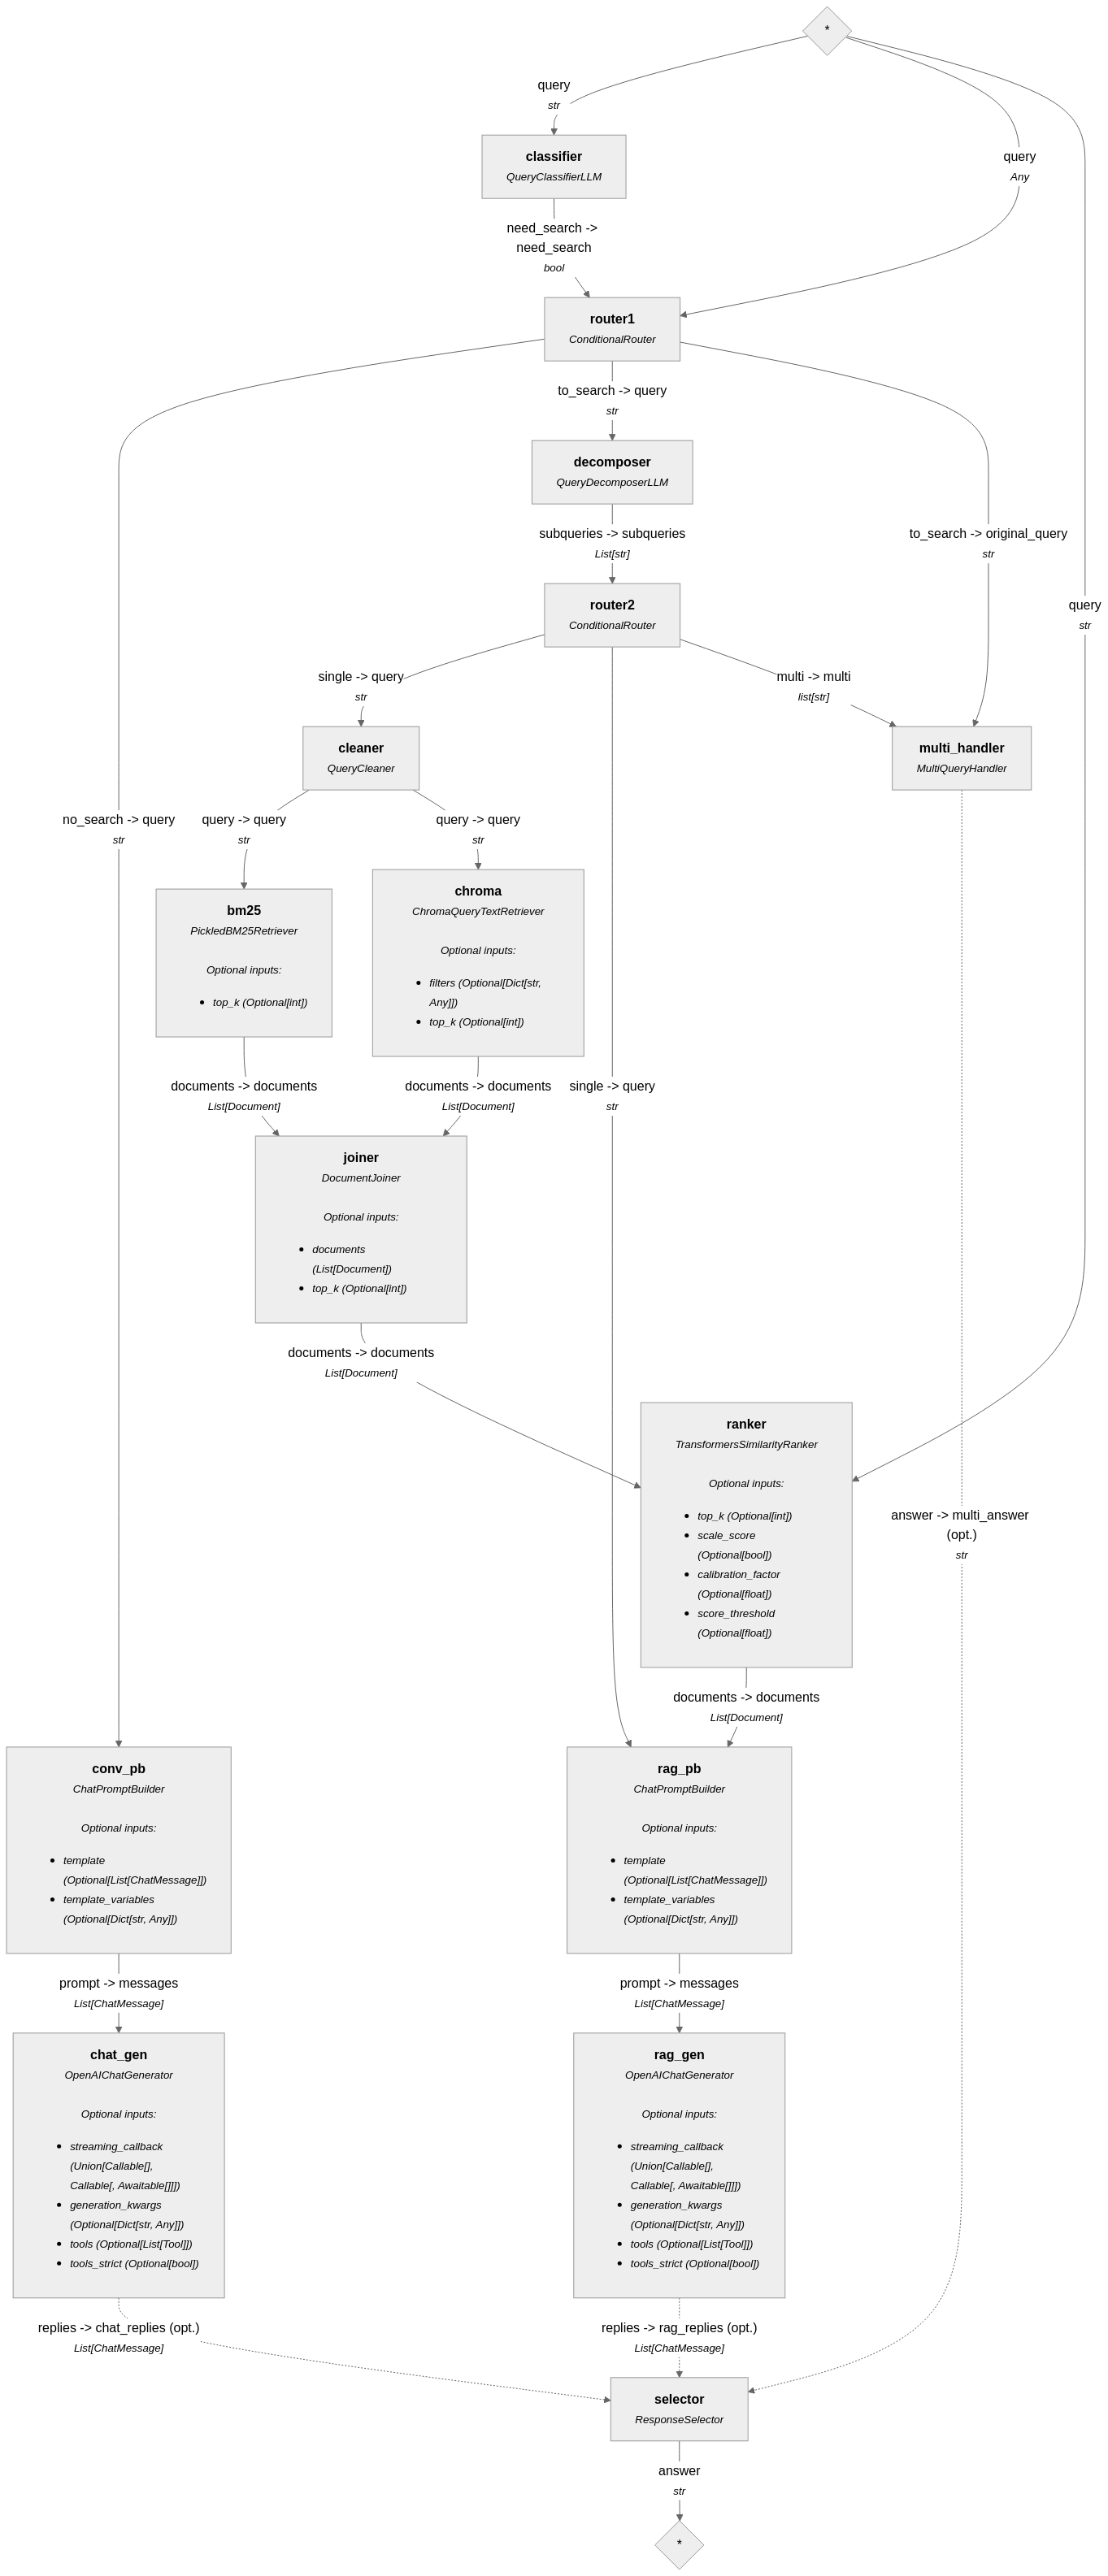

In [2]:
pipe.show()

In [3]:
# –°–ø–∏—Å–æ–∫ —Ç–µ—Å—Ç–æ–≤—ã—Ö –∑–∞–ø—Ä–æ—Å–æ–≤
test_queries = [
    "–ü—Ä–∏–≤–µ—Ç!",
    "–ö–∞–∫ –¥–µ–ª–∞?",
    "–ß—Ç–æ —Ç–∞–∫–æ–µ —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∫–æ–¥–∞?",
    "–°–ø–∞—Å–∏–±–æ –∑–∞ –ø–æ–º–æ—â—å.",
    "–ü–æ–∫–∞!",
    "–ß—Ç–æ —Ç—ã —É–º–µ–µ—à—å?",
    "–ì–¥–µ –Ω–∞–π—Ç–∏ –∏–Ω—Å—Ç—Ä—É–∫—Ü–∏—é –ø–æ –ø–æ–¥–∞—á–µ –∑–∞—è–≤–ª–µ–Ω–∏—è –Ω–∞ –ª—å–≥–æ—Ç—ã?",
    "–°–∫–æ–ª—å–∫–æ –¥–Ω–µ–π –æ—Ç–ø—É—Å–∫–∞ –ø–æ–ª–æ–∂–µ–Ω–æ —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–∞–º?",
    "–†–∞—Å—Å–∫–∞–∂–∏ –æ –Ω–æ–≤—ã—Ö –ø–æ–ª–∏—Ç–∏–∫–∞—Ö –æ—Ç–ø—É—Å–∫–∞ –∏ —Å–∫–æ–ª—å–∫–æ –¥–Ω–µ–π —Ç–µ–ø–µ—Ä—å –ø–æ–ª–æ–∂–µ–Ω–æ?",
    "–ö–∞–∫–∏–µ –ª—å–≥–æ—Ç—ã –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª—è–µ—Ç –∫–æ–º–ø–∞–Ω–∏—è –∏ –∫–∞–∫ –∏—Ö –æ—Ñ–æ—Ä–º–∏—Ç—å?",
    "–ö–∞–∫ –º–Ω–µ —Å—Ñ–æ—Ä–º–∏—Ä–æ–≤–∞—Ç—å –æ—Ç—á—ë—Ç –ø–æ KPI –∑–∞ –º–µ—Å—è—Ü –∏ –∫–∞–∫–∏–µ –º–µ—Ç—Ä–∏–∫–∏ –≤–∫–ª—é—á–∏—Ç—å?",
    "–ö–∞–∫–∏–µ –∏–Ω—Ç–µ–≥—Ä–∞—Ü–∏–∏ –ø–æ–¥–¥–µ—Ä–∂–∏–≤–∞–µ—Ç –Ω–∞—à–µ HR‚Äë–ø—Ä–∏–ª–æ–∂–µ–Ω–∏–µ –∏ –∫–∞–∫ –∏—Ö –Ω–∞—Å—Ç—Ä–æ–∏—Ç—å?",
    "–ö–∞–∫–∏–µ –¥–æ–∫—É–º–µ–Ω—Ç—ã –Ω—É–∂–Ω—ã –¥–ª—è –ø—Ä–æ–¥–ª–µ–Ω–∏—è –≤–∏–∑—ã?",
    "–ö–∞–∫–æ–≤–∞ –∑–∞—Ä–ø–ª–∞—Ç–Ω–∞—è –≤–∏–ª–∫–∞ –¥–ª—è –ø–æ–∑–∏—Ü–∏–∏ Data Scientist?",
    "–†–∞—Å—Å–∫–∞–∂–∏ –æ –ø–æ–ª–∏—Ç–∏–∫–µ –∫–æ–º–∞–Ω–¥–∏—Ä–æ–≤–æ–∫: –∫—É–¥–∞ –ø–æ–¥–∞–≤–∞—Ç—å –∑–∞—è–≤–∫—É –∏ –∫–∞–∫–∏–µ –¥–æ–∫—É–º–µ–Ω—Ç—ã –Ω—É–∂–Ω—ã?",
]

for query in test_queries:
    result = pipe.run({"query": query})
    answer = result["selector"]["answer"]
    print(f"–ó–∞–ø—Ä–æ—Å: {query}\n–û—Ç–≤–µ—Ç: {answer}\n{'‚îÄ'*60}\n")

INFO:haystack.core.pipeline.base:Warming up component ranker...
INFO:haystack.core.pipeline.pipeline:Running component classifier
DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'timeout': 60, 'files': None, 'json_data': {'messages': [{'role': 'user', 'content': '–¢—ã ‚Äî –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä –∑–∞–ø—Ä–æ—Å–æ–≤ –ø–æ –±–∞–∑–µ –∑–Ω–∞–Ω–∏–π.\n–ï—Å–ª–∏ –∑–∞–ø—Ä–æ—Å —Ç—Ä–µ–±—É–µ—Ç –ø–æ–∏—Å–∫–∞ ‚Äî –æ—Ç–≤–µ—Ç—å \'true\'. –ï—Å–ª–∏ –º–æ–∂–Ω–æ –æ—Ç–≤–µ—Ç–∏—Ç—å –±–µ–∑ –ø–æ–∏—Å–∫–∞ ‚Äî \'false\'.\n\n–ü—Ä–∏–º–µ—Ä—ã:\n–ó–∞–ø—Ä–æ—Å: "–ü—Ä–∏–≤–µ—Ç"\n–û—Ç–≤–µ—Ç: false\n\n–ó–∞–ø—Ä–æ—Å: "–ö–∞–∫ –¥–µ–ª–∞?"\n–û—Ç–≤–µ—Ç: false\n\n–ó–∞–ø—Ä–æ—Å: "–ß—Ç–æ —Ç–∞–∫–æ–µ GDPR?"\n–û—Ç–≤–µ—Ç: true\n\n–ó–∞–ø—Ä–æ—Å: "–°–∫–æ–ª—å–∫–æ –¥–Ω–µ–π –æ—Ç–ø—É—Å–∫–∞ –ø–æ–ª–æ–∂–µ–Ω–æ —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–∞–º?"\n–û—Ç–≤–µ—Ç: true\n\n–¢–µ–ø–µ—Ä—å –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä—É–π:\n–ó–∞–ø—Ä–æ—Å: "–ü—Ä–∏–≤–µ—Ç!"\n–û—Ç–≤–µ—Ç:'}], 'model': 'hf.co/IlyaGusev/saiga_yandexgpt_8b_gguf:Q4_0', 'max_tokens':

–ó–∞–ø—Ä–æ—Å: –ü—Ä–∏–≤–µ—Ç!
–û—Ç–≤–µ—Ç: –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ! –ß–µ–º —è –º–æ–≥—É –≤–∞–º –ø–æ–º–æ—á—å —Å–µ–≥–æ–¥–Ω—è? 
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ



DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Content-Type', b'application/json'), (b'Date', b'Mon, 21 Apr 2025 15:49:52 GMT'), (b'Content-Length', b'327')])
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
DEBUG:httpcore.http11:receive_response_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_body.complete
DEBUG:httpcore.http11:response_closed.started
DEBUG:httpcore.http11:response_closed.complete
DEBUG:openai._base_client:HTTP Response: POST http://localhost:11434/v1/chat/completions "200 OK" Headers({'content-type': 'application/json', 'date': 'Mon, 21 Apr 2025 15:49:52 GMT', 'content-length': '327'})
DEBUG:openai._base_client:request_id: None
INFO:haystack.core.pipeline.pipeline:Running component router1
INFO:haystack.core.pipeline.pipeline:Running component conv_pb
INFO:haystack.core.pipeline.pipeline:Running component chat_gen
DEBUG:openai._base_client:Req

–ó–∞–ø—Ä–æ—Å: –ö–∞–∫ –¥–µ–ª–∞?
–û—Ç–≤–µ—Ç: –û—Ç–ª–∏—á–Ω–æ! –†–∞–¥(–∞), —á—Ç–æ —Ç—ã –∑–¥–µ—Å—å –∏ –≥–æ—Ç–æ–≤ –ø–æ–º–æ—á—å —Å –ª—é–±—ã–º–∏ –≤–æ–ø—Ä–æ—Å–∞–º–∏ –∏–ª–∏ –∑–∞–¥–∞—á–∞–º–∏. –ö–∞–∫ —è –º–æ–≥—É –≤–∞–º —Å–æ–¥–µ–π—Å—Ç–≤–æ–≤–∞—Ç—å —Å–µ–≥–æ–¥–Ω—è?
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ



DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Content-Type', b'application/json'), (b'Date', b'Mon, 21 Apr 2025 15:49:54 GMT'), (b'Content-Length', b'324')])
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
DEBUG:httpcore.http11:receive_response_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_body.complete
DEBUG:httpcore.http11:response_closed.started
DEBUG:httpcore.http11:response_closed.complete
DEBUG:openai._base_client:HTTP Response: POST http://localhost:11434/v1/chat/completions "200 OK" Headers({'content-type': 'application/json', 'date': 'Mon, 21 Apr 2025 15:49:54 GMT', 'content-length': '324'})
DEBUG:openai._base_client:request_id: None
INFO:haystack.core.pipeline.pipeline:Running component router1
INFO:haystack.core.pipeline.pipeline:Running component decomposer
DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 

–ó–∞–ø—Ä–æ—Å: –ß—Ç–æ —Ç–∞–∫–æ–µ —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∫–æ–¥–∞?
–û—Ç–≤–µ—Ç: –ö–æ–Ω–µ—á–Ω–æ! –í–æ—Ç –ø–æ–¥—Ä–æ–±–Ω—ã–π –æ—Ç–≤–µ—Ç –Ω–∞ –≤–∞—à –≤–æ–ø—Ä–æ—Å –æ —Å–∏—Å—Ç–µ–º–∞—Ö –ø–∏—Ç–∞–Ω–∏—è –î–í–° —Å –ø—Ä–∏–Ω—É–¥–∏—Ç–µ–ª—å–Ω—ã–º –≤–æ—Å–ø–ª–∞–º–µ–Ω–µ–Ω–∏–µ–º:

1. –°–∏—Å—Ç–µ–º—ã –≥–∞–∑–æ–±–∞–ª–ª–æ–Ω–Ω–æ–≥–æ –æ–±–æ—Ä—É–¥–æ–≤–∞–Ω–∏—è (–ì–ë–û) –ø—Ä–µ–¥–Ω–∞–∑–Ω–∞—á–µ–Ω—ã –¥–ª—è –ø–µ—Ä–µ–≤–æ–¥–∞ –¥–∏–∑–µ–ª—å–Ω—ã—Ö –¥–≤–∏–≥–∞—Ç–µ–ª–µ–π –Ω–∞ –∞–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–Ω—ã–µ –≤–∏–¥—ã —Ç–æ–ø–ª–∏–≤–∞ (–ø—Ä–∏—Ä–æ–¥–Ω—ã–π –≥–∞–∑, –ø—Ä–æ–ø–∞–Ω-–±—É—Ç–∞–Ω). –û—Å–Ω–æ–≤–Ω—ã–µ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç—ã –ì–ë–û: —Ä–µ–¥—É–∫—Ç–æ—Ä—ã –≤—ã—Å–æ–∫–æ–≥–æ –∏ –Ω–∏–∑–∫–æ–≥–æ –¥–∞–≤–ª–µ–Ω–∏—è, –≥–∞–∑–æ–≤—ã–µ —Ñ–æ—Ä—Å—É–Ω–∫–∏, –º–∞–Ω–æ–º–µ—Ç—Ä—ã, –ø—Ä–µ–¥–æ—Ö—Ä–∞–Ω–∏—Ç–µ–ª—å–Ω—ã–µ –∫–ª–∞–ø–∞–Ω—ã, —Ñ–∏–ª—å—Ç—Ä. –ü—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–∞ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è –ì–ë–û:  
- –°–Ω–∏–∂–µ–Ω–∏–µ —Ä–∞—Å—Ö–æ–¥–∞ –¥–∏–∑–µ–ª—å–Ω–æ–≥–æ —Ç–æ–ø–ª–∏–≤–∞ –¥–æ 40% –ø—Ä–∏ –ø–µ—Ä–µ—Ö–æ–¥–µ –Ω–∞ –ø—Ä–∏—Ä–æ–¥–Ω—ã–π –≥–∞–∑
- –£–ª—É—á—à–µ–Ω–∏–µ —

DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Content-Type', b'application/json'), (b'Date', b'Mon, 21 Apr 2025 15:50:19 GMT'), (b'Content-Length', b'325')])
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
DEBUG:httpcore.http11:receive_response_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_body.complete
DEBUG:httpcore.http11:response_closed.started
DEBUG:httpcore.http11:response_closed.complete
DEBUG:openai._base_client:HTTP Response: POST http://localhost:11434/v1/chat/completions "200 OK" Headers({'content-type': 'application/json', 'date': 'Mon, 21 Apr 2025 15:50:19 GMT', 'content-length': '325'})
DEBUG:openai._base_client:request_id: None
INFO:haystack.core.pipeline.pipeline:Running component router1
INFO:haystack.core.pipeline.pipeline:Running component conv_pb
INFO:haystack.core.pipeline.pipeline:Running component chat_gen
DEBUG:openai._base_client:Req

–ó–∞–ø—Ä–æ—Å: –°–ø–∞—Å–∏–±–æ –∑–∞ –ø–æ–º–æ—â—å.
–û—Ç–≤–µ—Ç: –†–∞–¥ –±—ã–ª –ø–æ–º–æ—á—å! –ï—Å–ª–∏ —É –≤–∞—Å –≤–æ–∑–Ω–∏–∫–Ω—É—Ç –µ—â–µ –≤–æ–ø—Ä–æ—Å—ã –∏–ª–∏ –≤–∞–º –ø–æ–Ω–∞–¥–æ–±–∏—Ç—Å—è —Å–æ–≤–µ—Ç, –Ω–µ —Å—Ç–µ—Å–Ω—è–π—Ç–µ—Å—å –æ–±—Ä–∞—â–∞—Ç—å—Å—è. üòä 
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ



DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Content-Type', b'application/json'), (b'Date', b'Mon, 21 Apr 2025 15:50:20 GMT'), (b'Content-Length', b'325')])
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
DEBUG:httpcore.http11:receive_response_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_body.complete
DEBUG:httpcore.http11:response_closed.started
DEBUG:httpcore.http11:response_closed.complete
DEBUG:openai._base_client:HTTP Response: POST http://localhost:11434/v1/chat/completions "200 OK" Headers({'content-type': 'application/json', 'date': 'Mon, 21 Apr 2025 15:50:20 GMT', 'content-length': '325'})
DEBUG:openai._base_client:request_id: None
INFO:haystack.core.pipeline.pipeline:Running component router1
INFO:haystack.core.pipeline.pipeline:Running component conv_pb
INFO:haystack.core.pipeline.pipeline:Running component chat_gen
DEBUG:openai._base_client:Req

–ó–∞–ø—Ä–æ—Å: –ü–æ–∫–∞!
–û—Ç–≤–µ—Ç: –ù–∞–¥–µ—é—Å—å, –º—ã —Å–∫–æ—Ä–æ —É–≤–∏–¥–∏–º—Å—è —Å–Ω–æ–≤–∞! –ï—Å–ª–∏ —É —Ç–µ–±—è –µ—Å—Ç—å –µ—â–µ –≤–æ–ø—Ä–æ—Å—ã –∏–ª–∏ –ø–æ–∂–µ–ª–∞–Ω–∏—è, –Ω–µ —Å—Ç–µ—Å–Ω—è–π—Å—è –æ–±—Ä–∞—â–∞—Ç—å—Å—è. üòä
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ



DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Content-Type', b'application/json'), (b'Date', b'Mon, 21 Apr 2025 15:50:22 GMT'), (b'Content-Length', b'325')])
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
DEBUG:httpcore.http11:receive_response_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_body.complete
DEBUG:httpcore.http11:response_closed.started
DEBUG:httpcore.http11:response_closed.complete
DEBUG:openai._base_client:HTTP Response: POST http://localhost:11434/v1/chat/completions "200 OK" Headers({'content-type': 'application/json', 'date': 'Mon, 21 Apr 2025 15:50:22 GMT', 'content-length': '325'})
DEBUG:openai._base_client:request_id: None
INFO:haystack.core.pipeline.pipeline:Running component router1
INFO:haystack.core.pipeline.pipeline:Running component conv_pb
INFO:haystack.core.pipeline.pipeline:Running component chat_gen
DEBUG:openai._base_client:Req

–ó–∞–ø—Ä–æ—Å: –ß—Ç–æ —Ç—ã —É–º–µ–µ—à—å?
–û—Ç–≤–µ—Ç: –Ø —É–º–µ—é –ø–æ–Ω–∏–º–∞—Ç—å –µ—Å—Ç–µ—Å—Ç–≤–µ–Ω–Ω—ã–π —è–∑—ã–∫, –æ—Ç–≤–µ—á–∞—Ç—å –Ω–∞ –≤–æ–ø—Ä–æ—Å—ã –∏ –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª—è—Ç—å –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –∏–ª–∏ –∏–¥–µ–∏. –ú–æ–≥—É –ø–æ–º–æ–≥–∞—Ç—å —Å –ø–ª–∞–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ–º –¥–Ω—è, –≤—ã–ø–æ–ª–Ω–µ–Ω–∏–µ–º –∑–∞–¥–∞—á, —Ä–µ—à–µ–Ω–∏–µ–º –ø—Ä–æ–±–ª–µ–º –∏ –º–Ω–æ–≥–∏–º –¥—Ä—É–≥–∏–º! –ê —á—Ç–æ –∏–Ω—Ç–µ—Ä–µ—Å—É–µ—Ç —Ç–µ–±—è —Å–µ–≥–æ–¥–Ω—è?
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ



DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Content-Type', b'application/json'), (b'Date', b'Mon, 21 Apr 2025 15:50:24 GMT'), (b'Content-Length', b'324')])
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
DEBUG:httpcore.http11:receive_response_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_body.complete
DEBUG:httpcore.http11:response_closed.started
DEBUG:httpcore.http11:response_closed.complete
DEBUG:openai._base_client:HTTP Response: POST http://localhost:11434/v1/chat/completions "200 OK" Headers({'content-type': 'application/json', 'date': 'Mon, 21 Apr 2025 15:50:24 GMT', 'content-length': '324'})
DEBUG:openai._base_client:request_id: None
INFO:haystack.core.pipeline.pipeline:Running component router1
INFO:haystack.core.pipeline.pipeline:Running component decomposer
DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 

–ó–∞–ø—Ä–æ—Å: –ì–¥–µ –Ω–∞–π—Ç–∏ –∏–Ω—Å—Ç—Ä—É–∫—Ü–∏—é –ø–æ –ø–æ–¥–∞—á–µ –∑–∞—è–≤–ª–µ–Ω–∏—è –Ω–∞ –ª—å–≥–æ—Ç—ã?
–û—Ç–≤–µ—Ç: 
–í–æ–ø—Ä–æ—Å –∫–∞—Å–∞–µ—Ç—Å—è –æ–±—Å—É–∂–¥–µ–Ω–∏—è —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –∞—Å–ø–µ–∫—Ç–æ–≤ —Å–æ–∑–¥–∞–Ω–∏—è –≥–∞–∑–æ—Ç—É—Ä–±–∏–Ω–Ω—ã—Ö –¥–≤–∏–≥–∞—Ç–µ–ª–µ–π (–ì–¢–î), –≤–∫–ª—é—á–∞—è –∏—Ö –ø—Ä–æ–µ–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º —Å–∏—Å—Ç–µ–º –∞–≤—Ç–æ–º–∞—Ç–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–æ–≥–æ –ø—Ä–æ–µ–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏—è (–°–ê–ü–†) –∏ –≤–Ω–µ–¥—Ä–µ–Ω–∏—è —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏–π CALS-–∂–∏–∑–Ω–µ–Ω–Ω–æ–≥–æ —Ü–∏–∫–ª–∞ –∏–∑–¥–µ–ª–∏—è. –≠—Ç–æ—Ç –≤–æ–ø—Ä–æ—Å –∞–∫—Ç—É–∞–ª–µ–Ω –¥–ª—è –∞–≤–∏–∞—Ü–∏–æ–Ω–Ω–æ–π –ø—Ä–æ–º—ã—à–ª–µ–Ω–Ω–æ—Å—Ç–∏, —Ç–∞–∫ –∫–∞–∫ —Å–æ–≤—Ä–µ–º–µ–Ω–Ω—ã–µ —Ç–µ–Ω–¥–µ–Ω—Ü–∏–∏ —Ä–∞–∑–≤–∏—Ç–∏—è —Ç—Ä–µ–±—É—é—Ç –ø–æ–≤—ã—à–µ–Ω–∏—è —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç–∏ –ø—Ä–æ—Ü–µ—Å—Å–æ–≤ —Å–æ–∑–¥–∞–Ω–∏—è –ì–¢–î, —Å–æ–∫—Ä–∞—â–µ–Ω–∏—è —Å—Ä–æ–∫–æ–≤ —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–∏ –∏ —Å–Ω–∏–∂–µ–Ω–∏—è –æ–±—â–∏—Ö –∑–∞—Ç—Ä–∞—Ç –Ω–∞ –ø—Ä–∏–æ–±—Ä–µ—Ç–µ–Ω–∏–µ —ç—Ç–∏—Ö –∏–∑–¥–µ–ª–∏–π.

### –û—Å–Ω–æ–≤–

DEBUG:urllib3.connectionpool:https://eu.i.posthog.com:443 "POST /batch/ HTTP/1.1" 200 15
DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Content-Type', b'application/json'), (b'Date', b'Mon, 21 Apr 2025 15:51:01 GMT'), (b'Content-Length', b'324')])
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
DEBUG:httpcore.http11:receive_response_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_body.complete
DEBUG:httpcore.http11:response_closed.started
DEBUG:httpcore.http11:response_closed.complete
DEBUG:openai._base_client:HTTP Response: POST http://localhost:11434/v1/chat/completions "200 OK" Headers({'content-type': 'application/json', 'date': 'Mon, 21 Apr 2025 15:51:01 GMT', 'content-length': '324'})
DEBUG:openai._base_client:request_id: None
INFO:haystack.core.pipeline.pipeline:Running component router1
INFO:haystack.core.pipeline.pipeline:Running component decomposer
D

–ó–∞–ø—Ä–æ—Å: –°–∫–æ–ª—å–∫–æ –¥–Ω–µ–π –æ—Ç–ø—É—Å–∫–∞ –ø–æ–ª–æ–∂–µ–Ω–æ —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–∞–º?
–û—Ç–≤–µ—Ç: 
–°–æ–∑–¥–∞–Ω–∏–µ —Å–æ–≤—Ä–µ–º–µ–Ω–Ω—ã—Ö –≥–∞–∑–æ—Ç—É—Ä–±–∏–Ω–Ω—ã—Ö –¥–≤–∏–≥–∞—Ç–µ–ª–µ–π (–ì–¢–î) –≥—Ä–∞–∂–¥–∞–Ω—Å–∫–æ–π –∞–≤–∏–∞—Ü–∏–∏ —Ç—Ä–µ–±—É–µ—Ç —Ç—â–∞—Ç–µ–ª—å–Ω–æ–π –∏–Ω—Ç–µ–≥—Ä–∞—Ü–∏–∏ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏–π –∏ –ø—Ä–æ—Ü–µ—Å—Å–æ–≤, –≤–∫–ª—é—á–∞—è –∞–≤—Ç–æ–º–∞—Ç–∏–∑–∞—Ü–∏—é –ø—Ä–æ–µ–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏—è (–°–ê–ü–†), –º–∞—Ç–µ–º–∞—Ç–∏—á–µ—Å–∫–æ–µ –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏–µ, –º–Ω–æ–≥–æ–¥–∏—Å—Ü–∏–ø–ª–∏–Ω–∞—Ä–Ω—ã–µ —Ä–∞—Å—á–µ—Ç—ã –∏ —Å–∏—Å—Ç–µ–º—ã —É–ø—Ä–∞–≤–ª–µ–Ω–∏—è –∂–∏–∑–Ω–µ–Ω–Ω—ã–º —Ü–∏–∫–ª–æ–º –∏–∑–¥–µ–ª–∏—è. –í–æ—Ç –ø–æ–¥—Ä–æ–±–Ω—ã–π –æ—Ç–≤–µ—Ç —Å —É–∫–∞–∑–∞–Ω–∏–µ–º –æ—Å–Ω–æ–≤–Ω—ã—Ö –∏—Å—Ç–æ—á–Ω–∏–∫–æ–≤:

1. **–≠—Ç–∞–ø—ã —Ä–∞–∑–≤–∏—Ç–∏—è –°–ê–ü–† –≤ –∞–≤–∏–∞–¥–≤–∏–≥–∞—Ç–µ–ª–µ—Å—Ç—Ä–æ–µ–Ω–∏–∏**:
   - –í –º–æ–Ω–æ–≥—Ä–∞—Ñ–∏–∏ "–°–æ–≤—Ä–µ–º–µ–Ω–Ω—ã–µ —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏–∏ –ø—Ä–æ–µ–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏—è –∞–≤–∏–∞—Ü–∏–æ–Ω–Ω—ã—Ö –¥–≤–∏–≥–∞—Ç–µ–ª–µ–π" –ø–æ–¥ —Ä–µ–¥–∞–∫—Ü

DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Content-Type', b'application/json'), (b'Date', b'Mon, 21 Apr 2025 15:51:40 GMT'), (b'Content-Length', b'610')])
INFO:httpx:HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
DEBUG:httpcore.http11:receive_response_body.started request=<Request [b'POST']>
DEBUG:httpcore.http11:receive_response_body.complete
DEBUG:httpcore.http11:response_closed.started
DEBUG:httpcore.http11:response_closed.complete
DEBUG:openai._base_client:HTTP Response: POST http://localhost:11434/v1/chat/completions "200 OK" Headers({'content-type': 'application/json', 'date': 'Mon, 21 Apr 2025 15:51:40 GMT', 'content-length': '610'})
DEBUG:openai._base_client:request_id: None
INFO:haystack.core.pipeline.pipeline:Running component router1
INFO:haystack.core.pipeline.pipeline:Running component decomposer
DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 

In [ ]:
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph
from IPython.display import Image

# 1. –∫–æ–ø–∏—è –≥—Ä–∞—Ñ–∞ –∏ ¬´—á–∏—Ç–∞–µ–º—ã–µ¬ª –ø–æ–¥–ø–∏—Å–∏
H = pipe.graph.copy()
nice = {
    "router": "router",
    "txt_converter": "TXT",
    "csv_converter": "CSV",
    "md_converter": "MD",
    "json_converter": "JSON",
    "pdf_converter": "PDF",
    "docx_converter": "DOCX",
    "xlsx_converter": "XLSX",
    "tika_doc_converter": "DOC",
    "tika_epub_converter": "EPUB",
    "tika_xls_converter": "XLS",
    "tika_unclassified_converter": "fallback",
    "join": "join",
    "cleaner": "cleaner",
    "splitter": "splitter",
    "overlap_fix": "overlap_fix",
    "embedder": "embedder",
    "writer": "writer",
}
nx.relabel_nodes(H, nice, copy=False)

# 2. –≤ Graphviz‚Äë–æ–±—ä–µ–∫—Ç
A = to_agraph(H)
A.graph_attr.update(rankdir="TB", splines="ortho", bgcolor="white")

# —Å—Ç–∏–ª—å —É–∑–ª–æ–≤
A.node_attr.update(shape="box", style="filled,rounded", fillcolor="#fff4c2",
                   fontname="Arial", fontsize="11")

# 3. —Å–æ—Ö—Ä–∞–Ω—è–µ–º/–ø–æ–∫–∞–∑—ã–≤–∞–µ–º
A.draw("pipeline.png", prog="dot")      # SVG ‚Üí .svg    PNG ‚Üí .png
display(Image(filename="pipeline.png")) # Jupyter
